In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, LSTM, Dropout, BatchNormalization, Activation, Conv1D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import load_model

In [ ]:
def ctc_loss(y_true, y_pred):
    input_length = tf.ones(shape=(tf.shape(y_pred)[0], 1), dtype=tf.float32) * tf.cast(tf.shape(y_pred)[1], dtype=tf.float32)
    label_length = tf.math.reduce_sum(tf.cast(y_true != -1, tf.int32), axis=-1, keepdims=True)
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

[ WARN:0@8.943] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ72.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8.987] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ81.jpg'): can't open/read file: check file path/integrity
[ WARN:0@9.724] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ238.jpg'): can't open/read file: check file path/integrity
[ WARN:0@9.773] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ250.jpg'): can't open/read file: check file path/integrity
[ WARN:0@10.028] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ324.jpg'): can't open/read file: check file path/integrity
[ WARN:0@11.251] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageMQ174.jpg'): can't open/read file: check file path/integrity


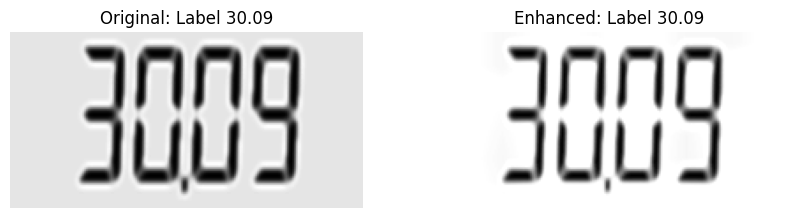

In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt


def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def adjust_brightness(image, value=30):
    return cv2.convertScaleAbs(image, alpha=1, beta=value)

def adjust_gamma(image, gamma=1.5):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def load_and_resize_data(csv_file, images_folder, resize_width=200, resize_height=100):
    df = pd.read_csv(csv_file, delimiter=";")
    images = []
    enhanced_images = []
    labels = []

    for index, row in df.iterrows():
        img_path = f"{images_folder}/{row['image']}"
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        if image is not None:
            grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(grayscale_image, (resize_width, resize_height))
            
            enhanced_image = normalize_image(resized_image)
            enhanced_image = apply_clahe(enhanced_image)
            enhanced_image = adjust_brightness(enhanced_image, value=30)
            enhanced_image = adjust_gamma(enhanced_image, gamma=1.5)

            images.append(resized_image)
            enhanced_images.append(enhanced_image)
            labels.append(row['label'])
    
    return np.array(images), np.array(enhanced_images), np.array(labels)

csv_file = '/kaggle/input/finaldatasetv2/finaldatasetV2.csv'
image_dir = '/kaggle/input/finaldatasetv2/gambar'

images, enhanced_images, labels = load_and_resize_data(csv_file, image_dir)

index = 550  
plt.figure(figsize=(10, 5))

# Gambar original
plt.subplot(1, 2, 1)
plt.imshow(images[index], cmap='gray')
plt.title(f"Original: Label {labels[index]}")
plt.axis('off')

# Gambar enhanced
plt.subplot(1, 2, 2)
plt.imshow(enhanced_images[index], cmap='gray')
plt.title(f"Enhanced: Label {labels[index]}")
plt.axis('off')

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras import regularizers


def build_crnn_model_with_ctc(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),  # input_shape  (100, 200, 1)
        
        layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal'),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        
        layers.Conv2D(256, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        
        layers.Conv2D(256, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Reshape(target_shape=(12, -1)),  
        
        layers.Conv1D(256, 3, activation="relu", padding="same", kernel_initializer='he_normal'),
        layers.Conv1D(128, 1, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_initializer='he_normal', dropout=0.4)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_initializer='he_normal', dropout=0.4)),
       
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=21e-4), loss=ctc_loss)
    
    return model



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


csv_file = '/kaggle/input/finaldatasetv2/finaldatasetV2.csv'
images_folder = '/kaggle/input/finaldatasetv2/gambar'

original_images, enhanced_images, labels = load_and_resize_data(csv_file, images_folder)
images = enhanced_images

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

label_to_int = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '.': 10}
num_classes = len(label_to_int)+1

def encode_labels(labels, max_length=None):
    encoded = []
    for label in labels:
        encoded_label = []
        for char in str(label):
            if char == '.':  
                encoded_label.append(10)  
            elif char.isdigit(): 
                encoded_label.append(int(char))  
            else:
                pass
        encoded.append(encoded_label)
    
    if max_length:
        encoded = pad_sequences(encoded, padding='post', maxlen=max_length, value=-1) 
    return np.array(encoded, dtype=np.int32)

max_label_length = max([len(str(label)) for label in y_train])

y_train_encoded = encode_labels(y_train, max_length=max_label_length)
y_val_encoded = encode_labels(y_val, max_length=max_label_length)
y_test_encoded = encode_labels(y_test, max_length=max_label_length)

print(f"Encoded training labels shape: {y_train_encoded.shape}")
print(f"Encoded validation labels shape: {y_val_encoded.shape}")
print(f"Encoded test labels shape: {y_test_encoded.shape}")

input_shape = (100, 200, 1) 
model = build_crnn_model_with_ctc(input_shape, num_classes)
model.summary()

[ WARN:0@19.952] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ72.jpg'): can't open/read file: check file path/integrity
[ WARN:0@19.990] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ81.jpg'): can't open/read file: check file path/integrity
[ WARN:0@20.691] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ238.jpg'): can't open/read file: check file path/integrity
[ WARN:0@20.737] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ250.jpg'): can't open/read file: check file path/integrity
[ WARN:0@20.990] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageLQ324.jpg'): can't open/read file: check file path/integrity
[ WARN:0@22.142] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/finaldatasetv2/gambar/imageMQ174.jpg'): can't open/read file: check file path/integrity


Encoded training labels shape: (1740, 6)
Encoded validation labels shape: (217, 6)
Encoded test labels shape: (218, 6)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 100, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 100, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 12, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 12, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 12, 256)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        32,89

 Total params: 1,872,268 (7.14 MB)

 Trainable params: 1,870,284 (7.13 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
early_stopping_patience = 10
early_stopping = EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

history = model.fit(X_train, y_train_encoded, 
                    validation_data=(X_val, y_val_encoded), 
                    epochs=100,batch_size=6, callbacks=early_stopping)

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f'Final Training Loss: {train_loss:.4f}')
print(f'Final Validation Loss: {val_loss:.4f}')

Epoch 1/100


2025-02-14 06:51:24.131729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


290/290 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 12.9814 - val_loss: 9.9811
Epoch 2/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 9.4448 - val_loss: 9.1360
Epoch 3/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 7.4688 - val_loss: 5.3389
Epoch 4/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 5.8467 - val_loss: 5.4811
Epoch 5/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 4.8465 - val_loss: 3.8373
Epoch 6/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 3.9395 - val_loss: 2.9122
Epoch 7/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 3.3828 - val_loss: 2.0458
Epoch 8/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 2.8574 - val_loss: 1.8367
Epoch 9/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 2.2148 - val_loss: 1.6836
Epoch 10/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 1.8208 - val_loss: 1.4986
Epoch 11/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 1.6697 - val_loss: 1.4798
Epoch 12/100
290/290 ━━━━━━━━━

In [ ]:
import numpy as np
import tensorflow as tf

def predict_on_test_data(X_test, y_test, model):
    y_pred = model.predict(X_test)
    input_length = np.full((y_pred.shape[0],), y_pred.shape[1], dtype=np.int32)
    decoded_predictions, _ = tf.keras.backend.ctc_decode(y_pred, input_length)
    decoded_predictions = np.array(decoded_predictions[0])

    correct_predictions = 0
    
    for i in range(len(X_test)):
        true_label = y_test[i]  
        predicted_label = decoded_predictions[i] 
        
        true_label = true_label[true_label != -1]
        predicted_label = predicted_label[predicted_label != -1]
        
        if np.array_equal(predicted_label, true_label):
            correct_predictions += 1
        
        print(f"Predicted: {predicted_label}, True label: {true_label}")
    
    total_samples = len(X_test)
    accuracy = (correct_predictions / total_samples) * 100
    
    print(f"\nTotal Correct Predictions: {correct_predictions}/{total_samples}")
    print(f"Accuracy: {accuracy:.2f}%")

predict_on_test_data(X_test, y_test_encoded, model)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
Predicted: [ 1  0  9 10  2], True label: [ 1  0  9 10  2]
Predicted: [ 3  0 10  7  6], True label: [ 3  0 10  7  6]
Predicted: [ 2 10  0  4  3], True label: [ 2 10  0  4  3]
Predicted: [ 4  4 10  1], True label: [ 4  4 10  1]
Predicted: [ 4  5  1 10  1], True label: [ 4  5  1 10  1]
Predicted: [ 6  1 10  0], True label: [ 6  1 10  0]
Predicted: [ 5  0 10  0  2], True label: [ 5  0 10  0  2]
Predicted: [ 1  2  0 10  0], True label: [ 1  2  0 10  0]
Predicted: [ 4 10  6], True label: [ 4 10  6]
Predicted: [ 5  8 10  0  1], True label: [ 5  8 10  0  1]
Predicted: [ 2  3 10  9], True label: [ 2  3 10  9]
Predicted: [ 2  7 10  0  1], True label: [ 2  7 10  0  1]
Predicted: [ 3  0 10  0  1], True label: [ 3  0 10  0  1]
Predicted: [ 7  3 10  0], True label: [ 7  3 10  0]
Predicted: [ 3  0 10  0], True label: [ 2  1  3 10  0]
Predicted: [ 2 10  0  3  8], True label: [ 2 10  0  3  8]
Predicted: [ 8  5 10  0  1], True label: [ 8  5 10  0  1]
Predicted: [ 1

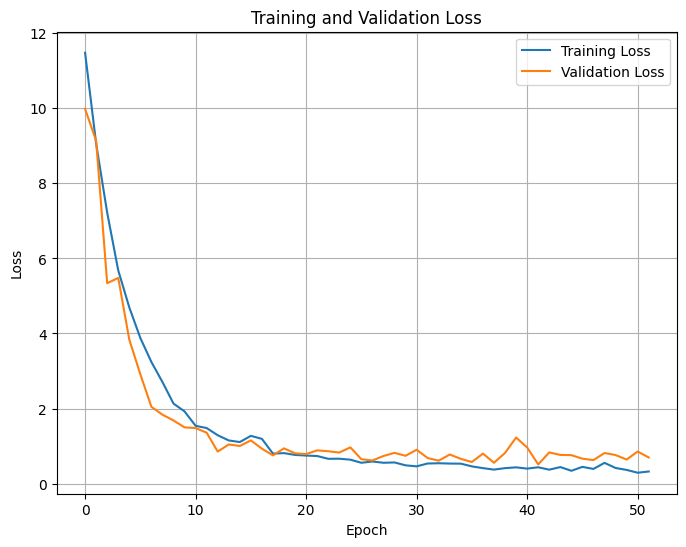

Final Training Loss: 0.3230
Final Validation Loss: 0.6972


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f'Final Training Loss: {train_loss:.4f}')
print(f'Final Validation Loss: {val_loss:.4f}')

In [14]:
!pip install jiwer

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import numpy as np
import seaborn as sns
from jiwer import wer, cer
import tensorflow as tf
import keras

def evaluate_ocr_with_confusion_matrix(model, X_test, y_test_encoded, label_map):
    y_pred = model.predict(X_test)
    
    input_len = np.ones(y_pred.shape[0]) * y_pred.shape[1]
    y_pred_decoded = tf.keras.backend.ctc_decode(y_pred, input_length=input_len, greedy=True)[0][0]

    y_pred_labels = []
    for pred in y_pred_decoded:
        if isinstance(pred, tf.Tensor): 
            pred = pred.numpy()  
        pred_text = ''.join([label_map[c] for c in pred if c != -1])  
        y_pred_labels.append(pred_text)

    y_true_labels = []
    for true_seq in y_test_encoded:
        if isinstance(true_seq, tf.Tensor):  
            true_seq = true_seq.numpy()  
        true_text = ''.join([label_map[c] for c in true_seq if c != -1]) 
        y_true_labels.append(true_text)

    min_len = min(len(y_true_labels), len(y_pred_labels))
    y_true_labels = y_true_labels[:min_len]
    y_pred_labels = y_pred_labels[:min_len]
    
    word_error_rate = wer(y_true_labels, y_pred_labels)
    char_error_rate = cer(y_true_labels, y_pred_labels)
    
    print(f'Word Error Rate (WER): {word_error_rate:.4f}')
    print(f'Character Error Rate (CER): {char_error_rate:.4f}')

    return word_error_rate, char_error_rate

label_map = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '.'}

cer = evaluate_ocr_with_confusion_matrix(model, X_test, y_test_encoded, label_map)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Word Error Rate (WER): 0.0963
Character Error Rate (CER): 0.0361


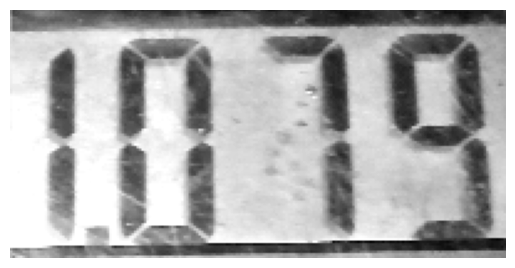

In [ ]:
images_folder = '/kaggle/input/croptimbtest'

enhanced_images = load_and_preprocess_images(images_folder)

index=4
plt.imshow(enhanced_images[index], cmap='gray')
plt.axis('off')

plt.show()

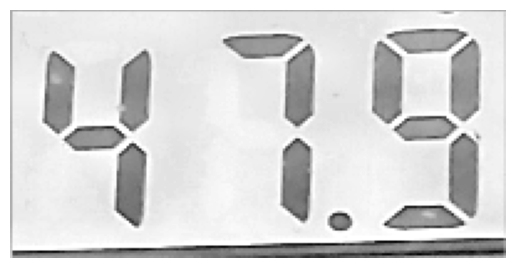

In [ ]:
def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def adjust_brightness(image, value=30):
    return cv2.convertScaleAbs(image, alpha=1, beta=value)

def adjust_gamma(image, gamma=1.5):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def load_and_preprocess_images(images_folder, resize_width=200, resize_height=100):
    images_list = os.listdir(images_folder)
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp'] 
    enhanced_images = []

    for img_name in images_list:
        if os.path.splitext(img_name)[1].lower() in valid_extensions:
            img_path = os.path.join(images_folder, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)  
            if image is not None:
                grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                resized_image = cv2.resize(grayscale_image, (resize_width, resize_height))
                enhanced_image = normalize_image(resized_image)
                enhanced_image = apply_clahe(enhanced_image)
                enhanced_image = adjust_brightness(enhanced_image, value=30)
                enhanced_image = adjust_gamma(enhanced_image, gamma=1.5)

                enhanced_images.append(enhanced_image)
    
    return np.array(enhanced_images)

images_folder = '/kaggle/input/croptestkecilfixed/croptestkecil'

enhance_images = load_and_preprocess_images(images_folder)

index=4
plt.imshow(enhance_images[index], cmap='gray')
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Predicted: [ 0 10  1  2  6]


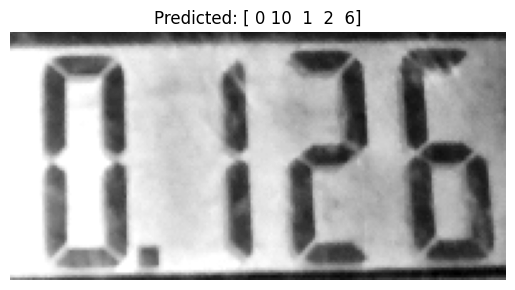

Predicted: [ 0 10  3  0  7]


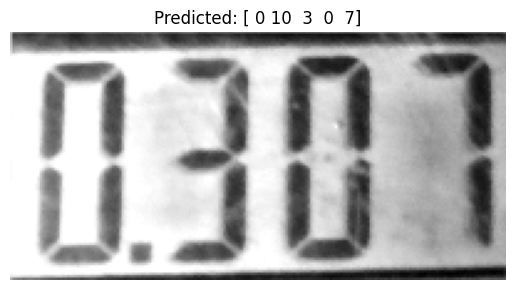

Predicted: [ 0 10  0  5]


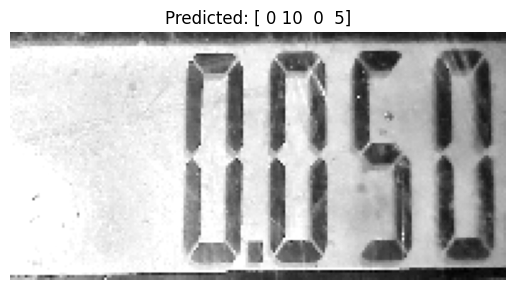

Predicted: [ 0 10  1  8  1]


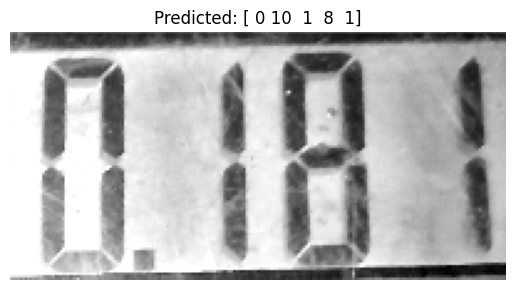

Predicted: [ 1 10  0  7  9]


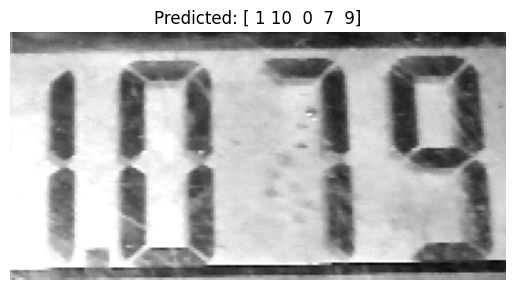

Predicted: [ 0 10  0  3  5]


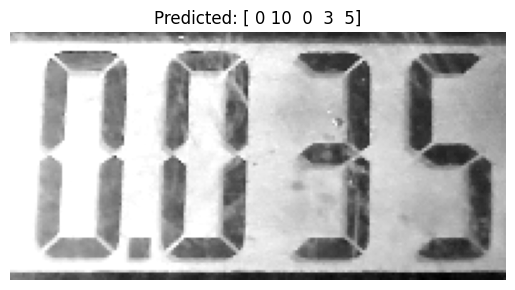

Predicted: [ 1 10  2  0  6]


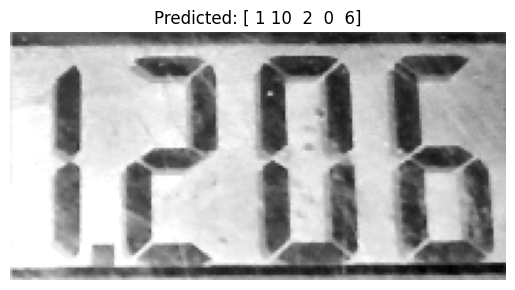

Predicted: [ 0 10  1  3  1]


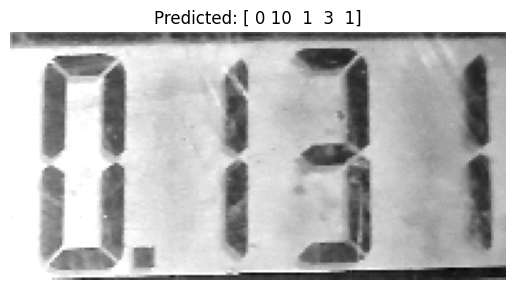

Predicted: [ 0 10  2  5  7]


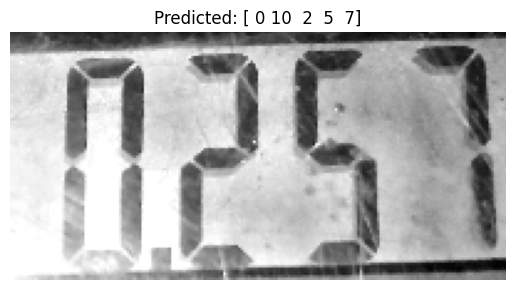

Predicted: [ 1 10  2  2]


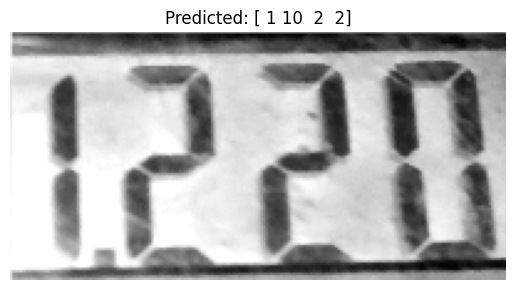

In [ ]:
def predict_on_test_data(X_test, model):
    y_pred = model.predict(X_test)
    input_length = np.full((y_pred.shape[0],), y_pred.shape[1], dtype=np.int32)
    decoded_predictions, _ = tf.keras.backend.ctc_decode(y_pred, input_length)
    decoded_predictions = np.array(decoded_predictions[0])

    for i in range(len(X_test)):
        predicted_label = decoded_predictions[i]  
        
        predicted_label = predicted_label[predicted_label != -1]
        
        print(f"Predicted: {predicted_label}")
        
        plt.imshow(X_test[i], cmap='gray')
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

ytest = enhanced_images

predict_on_test_data(ytest, model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted: [ 1  3  1 10  3]


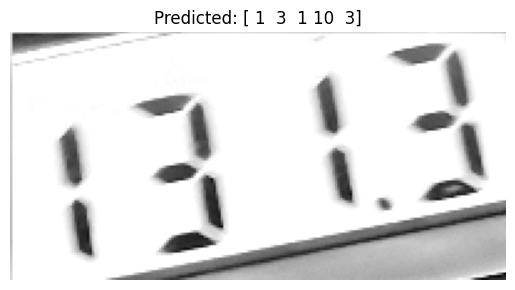

Predicted: [ 2  7 10  7]


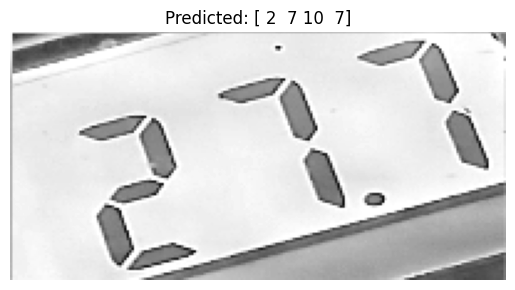

Predicted: [ 2  2 10  4]


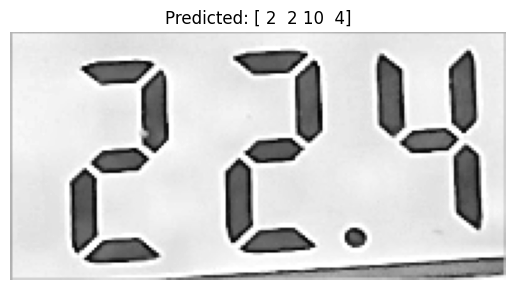

Predicted: [ 1  4  0 10  6]


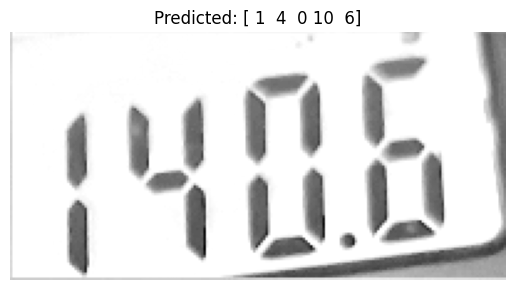

Predicted: [ 4  7 10  9]


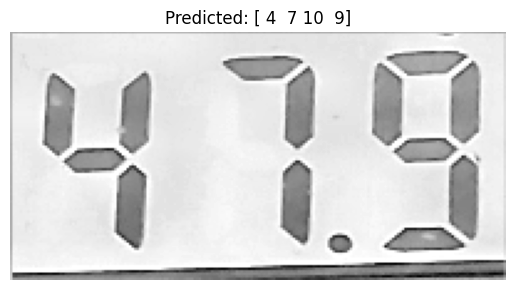

Predicted: [ 3  7  6 10  2]


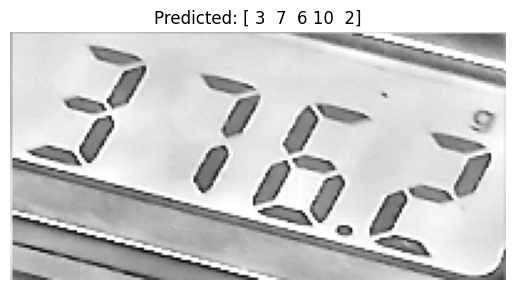

Predicted: [ 3 10  5]


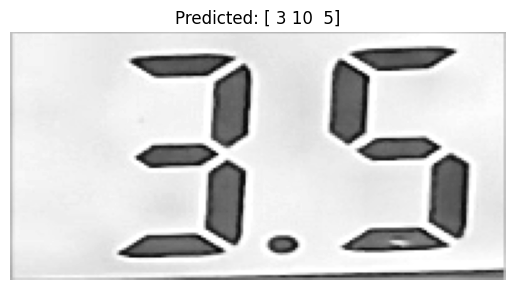

Predicted: [ 7  4 10  4]


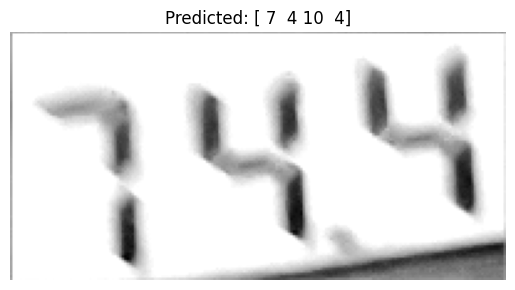

Predicted: [ 1  0  2 10  2]


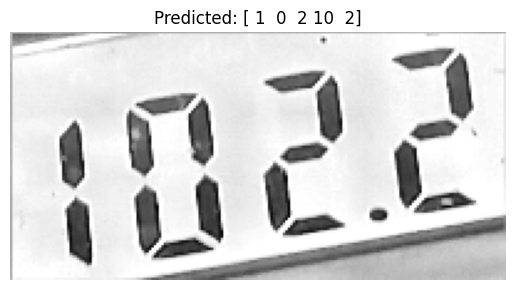

Predicted: [ 1  0 10  6]


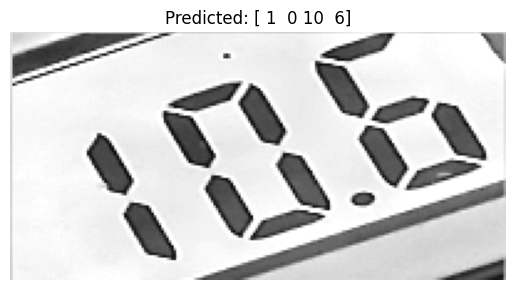

Predicted: [ 9  9 10  5]


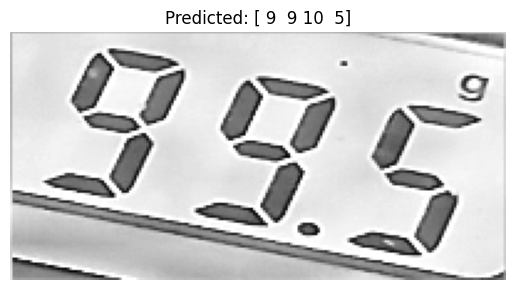

Predicted: [ 1  4  3 10  0]


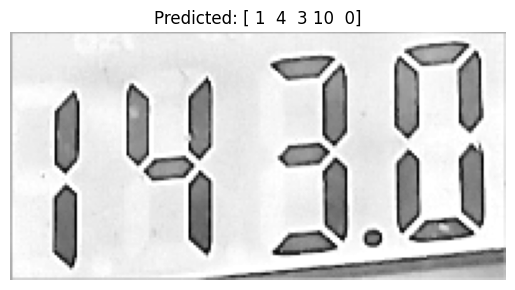

Predicted: [ 2  6 10  5]


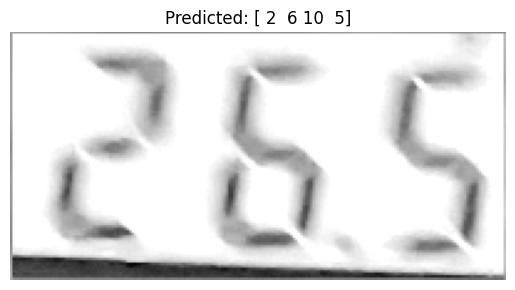

Predicted: [ 5  2 10  5]


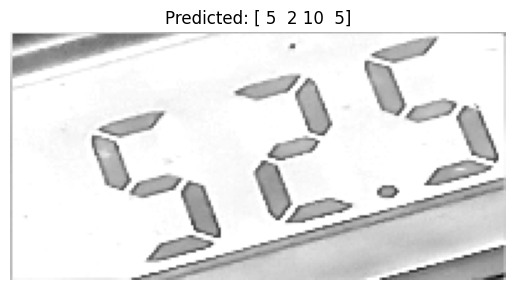

Predicted: [ 3 10  5]


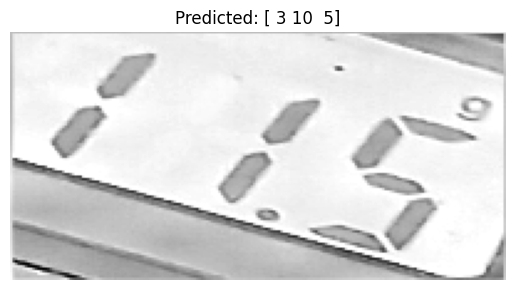

Predicted: [ 2  5 10  0]


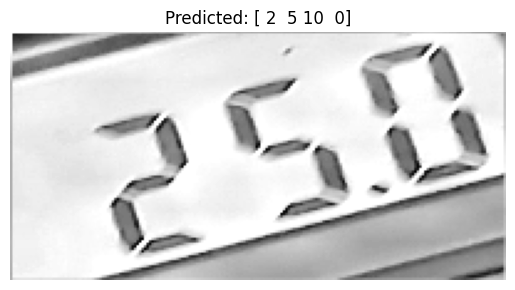

Predicted: [ 1  6 10  6]


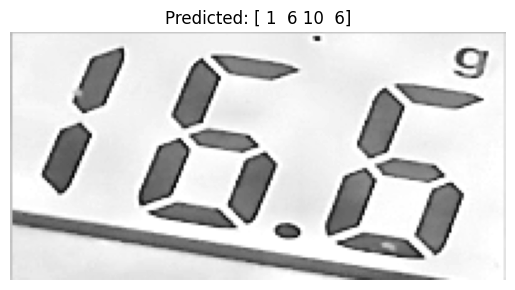

Predicted: [ 1  1  5 10  3]


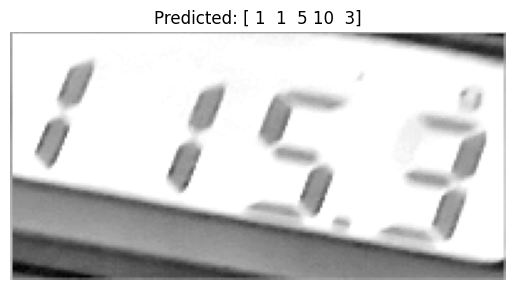

Predicted: [ 2  6  3 10  0]


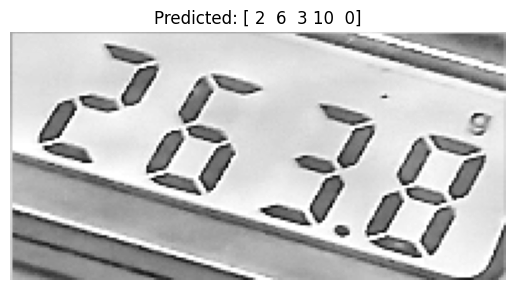

Predicted: [ 6  8 10  8]


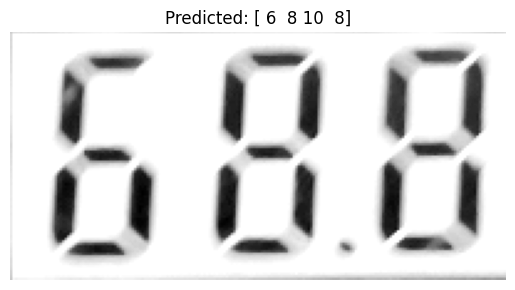

Predicted: [ 5  1 10  6]


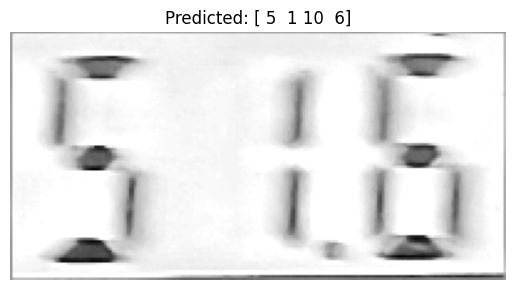

Predicted: [ 7  9 10  1]


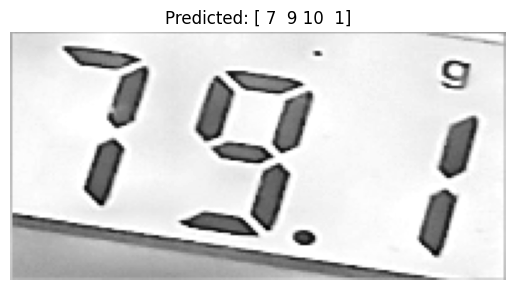

Predicted: [ 1  1  9 10  4]


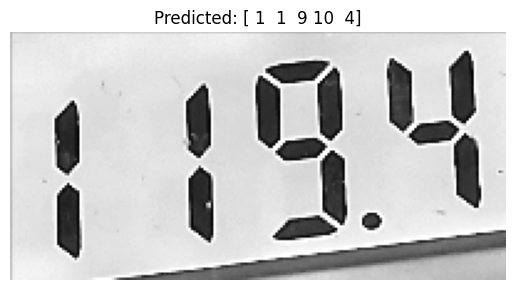

Predicted: [ 2  5  5 10  0]


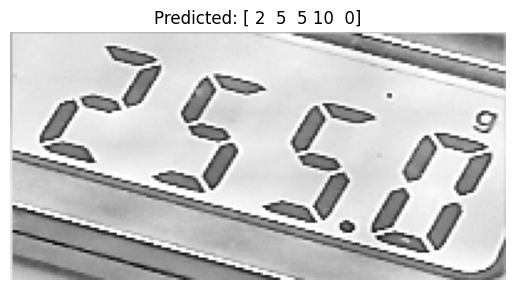

Predicted: [ 4  4 10  0]


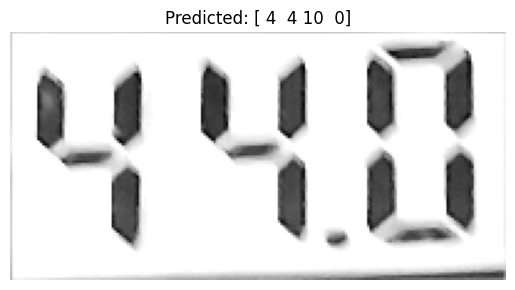

Predicted: [ 4  8 10  5]


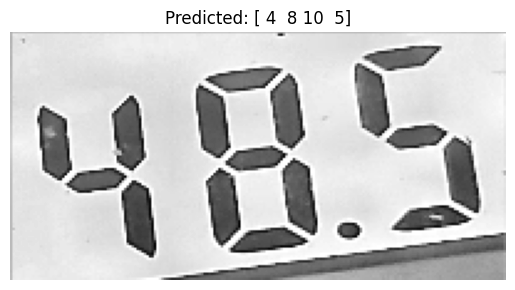

Predicted: [ 8  7 10  1]


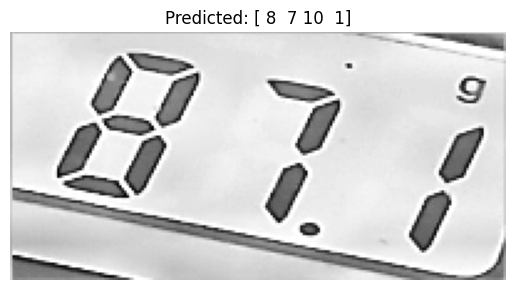

Predicted: [ 8  1 10  7]


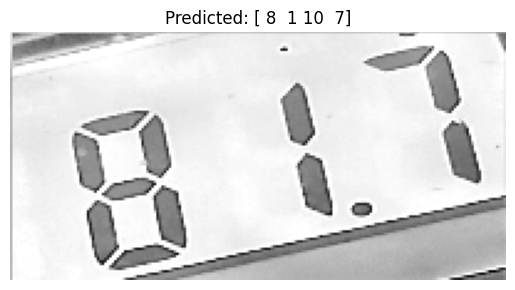

Predicted: [ 1  0  5 10  1]


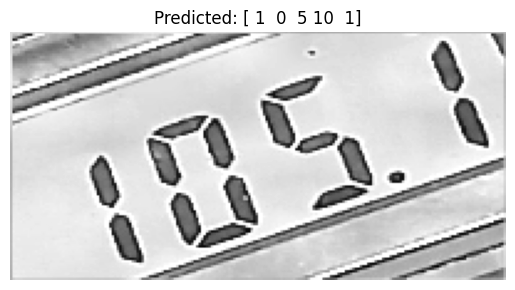

Predicted: [ 1  0  5 10  8]


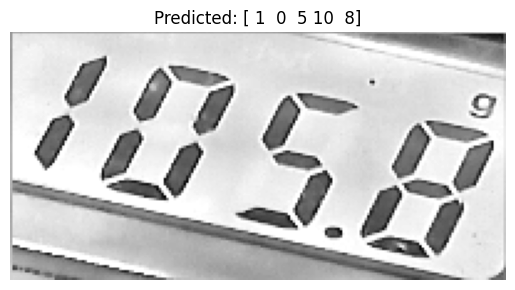

Predicted: [ 7  4 10  6]


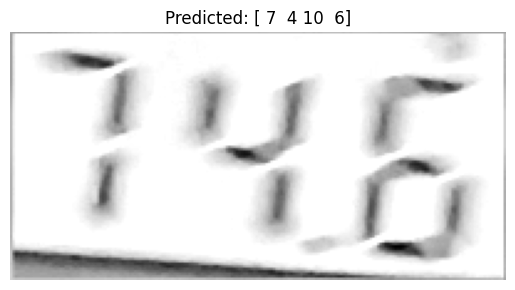

Predicted: [ 5  0 10  3]


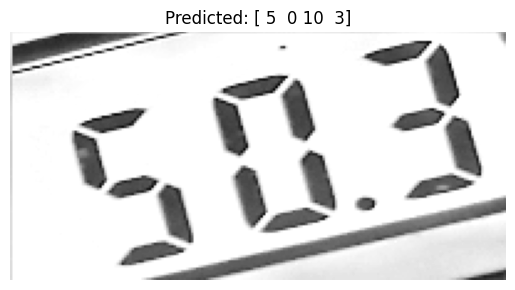

Predicted: [ 1  4  2 10  7]


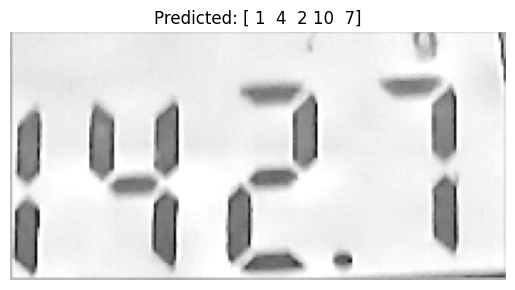

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import load_model

def predict_on_test_data(X_test, model):
    y_pred = model.predict(X_test)
    input_length = np.full((y_pred.shape[0],), y_pred.shape[1], dtype=np.int32)
    decoded_predictions, _ = tf.keras.backend.ctc_decode(y_pred, input_length)
    decoded_predictions = np.array(decoded_predictions[0])

    for i in range(len(X_test)):
        predicted_label = decoded_predictions[i]  
        
        predicted_label = predicted_label[predicted_label != -1]
        
        print(f"Predicted: {predicted_label}")
        
        plt.imshow(X_test[i], cmap='gray')
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

ytest = enhance_images

predict_on_test_data(ytest, model)

In [ ]:
save_path_h5 = os.path.join('/kaggle/working/', 'modelBAGUSV2.h5')

model.save(save_path_h5)
print(f"Model saved in HDF5 format at '{save_path_h5}'")

Model saved in HDF5 format at '/kaggle/working/modelBAGUSV2.h5'
